In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
# this is written as a tensorflow "layer".  it's just a vector the same size as the
# output of the previous layer. the vector is initialized randomly, but we'll use
# gradient descent to update the values in the vector
#
# it's purpose is to be appended to the beginning of the sequence of vectors fed into
# the transformer.  then after the transformer runs on the whole data, we just grab
# the resulting zero-th vector...the class token...and use that as the portfolio weights
class ClassToken(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

In [ ]:
def build_ViT(n,m,block_size,hidden_dim,num_layers,num_heads,key_dim,mlp_dim,dropout_rate,num_classes):
    # n is number of rows of blocks
    # m is number of cols of blocks
    # block_size is number of pixels (with rgb) in each block

    inp = tf.keras.layers.Input(shape=(n*m,block_size))
    inp2 = tf.keras.layers.Input(shape=(n*m))
    mid = tf.keras.layers.Dense(hidden_dim)(inp) # transform to vectors with different dimension
    # the positional embeddings
#     positions = tf.range(start=0, limit=n*m, delta=1)
    emb = tf.keras.layers.Embedding(input_dim=n*m, output_dim=hidden_dim)(inp2) # learned positional embedding for each of the n*m possible possitions
    mid = mid + emb # for some reason, tf.keras.layers.Add causes an error, but + doesn't?
    # create and append class token to beginning of all input vectors
    token = ClassToken()(mid) # append class token to beginning of sequence
    mid = tf.keras.layers.Concatenate(axis=1)([token, mid])

    for l in range(num_layers): # how many Transformer Head layers are there?
        ln  = tf.keras.layers.LayerNormalization()(mid) # normalize
        mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=key_dim,value_dim=key_dim)(ln,ln,ln) # self attention!
        add = tf.keras.layers.Add()([mid,mha]) # add and norm
        ln  = tf.keras.layers.LayerNormalization()(add)
        den = tf.keras.layers.Dense(mlp_dim,activation='gelu')(ln) # maybe should be relu...who knows...
        den = tf.keras.layers.Dropout(dropout_rate)(den) # regularization
        den = tf.keras.layers.Dense(hidden_dim)(den) # back to the right dimensional space
        den = tf.keras.layers.Dropout(dropout_rate)(den)
        mid = tf.keras.layers.Add()([den,add]) # add and norm again
    ln = tf.keras.layers.LayerNormalization()(mid)
    fl = ln[:,0,:] # just grab the class token for each image in batch
    clas = tf.keras.layers.Dense(num_classes,activation='softmax')(fl) # probability that the image is in each category
    mod = tf.keras.models.Model([inp,inp2],clas)
    mod.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return mod

In [ ]:
n = 4
m = 4
block_size = 49
hidden_dim = 100
num_layers = 6
num_heads = 4
key_dim = hidden_dim//num_heads # usually good practice for key_dim to be hidden_dim//num_heads...this is why we do Multi-Head attention
mlp_dim = hidden_dim
dropout_rate = 0.1
num_classes = 10



trans = build_ViT(n,m,block_size,hidden_dim,num_layers,num_heads,key_dim,mlp_dim,dropout_rate,num_classes)
trans.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 16, 49)]             0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 dense_28 (Dense)            (None, 16, 100)              5000      ['input_5[0][0]']             
                                                                                                  
 embedding_2 (Embedding)     (None, 16, 100)              1600      ['input_6[0][0]']             
                                                                                            

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

ndata_train = x_train.shape[0]
ndata_test = x_test.shape[0]

In [ ]:
#def convert_to_ones(arr):
#    return [1 if num > 0 else num for num in arr]

In [ ]:
#for i in range(x_train.shape[0]):
#  for j in range(x_train.shape[1]):
#    x_train[i][j]=convert_to_ones(x_train[i][j])

#for i in range(x_test.shape[0]):
#  for j in range(x_test.shape[1]):
#    x_test[i][j]=convert_to_ones(x_test[i][j])

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
import math

block_length= int(math.sqrt(block_size))

In [ ]:
x_train_ravel = np.zeros((ndata_train,n*m,block_size))
for img in range(ndata_train):
    ind = 0
    for row in range(n):
        for col in range(m):
            x_train_ravel[img,ind,:] = x_train[img,(row*block_length):((row+1)*block_length),(col*block_length):((col+1)*block_length)].ravel()
            ind += 1


In [ ]:
x_test_ravel = np.zeros((ndata_test,n*m,block_size))
for img in range(ndata_test):
    ind = 0
    for row in range(n):
        for col in range(m):
            x_test_ravel[img,ind,:] = x_test[img,(row*block_length):((row+1)*block_length),(col*block_length):((col+1)*block_length)].ravel()
            ind += 1

In [ ]:
pos_feed_train = np.array([list(range(n*m))]*ndata_train)
pos_feed_test = np.array([list(range(n*m))]*ndata_test)

In [ ]:
history = trans.fit([x_train_ravel,pos_feed_train],y_train,epochs=200,batch_size = 600,validation_split=0.2)

Epoch 1/200
80/80 [==============================] - 27s 84ms/step - loss: 1.4481 - accuracy: 0.4981 - val_loss: 0.6041 - val_accuracy: 0.8013
Epoch 2/200
80/80 [==============================] - 5s 68ms/step - loss: 0.4856 - accuracy: 0.8452 - val_loss: 0.2595 - val_accuracy: 0.9216
Epoch 3/200
80/80 [==============================] - 5s 63ms/step - loss: 0.2566 - accuracy: 0.9206 - val_loss: 0.1766 - val_accuracy: 0.9463
Epoch 4/200
80/80 [==============================] - 5s 63ms/step - loss: 0.1810 - accuracy: 0.9444 - val_loss: 0.1400 - val_accuracy: 0.9580
Epoch 5/200
80/80 [==============================] - 5s 65ms/step - loss: 0.1466 - accuracy: 0.9539 - val_loss: 0.1166 - val_accuracy: 0.9651
Epoch 6/200
80/80 [==============================] - 5s 63ms/step - loss: 0.1179 - accuracy: 0.9631 - val_loss: 0.1089 - val_accuracy: 0.9678
Epoch 7/200
80/80 [==============================] - 5s 64ms/step - loss: 0.1029 - accuracy: 0.9675 - val_loss: 0.0978 - val_accuracy: 0.9707
Epoch

In [ ]:
training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []
epochs = []

In [ ]:
training_loss.extend(history.history['loss'])
training_accuracy.extend(history.history['accuracy'])
validation_loss.extend(history.history['val_loss'])
validation_accuracy.extend(history.history['val_accuracy'])
epochs.extend(range(1, len(history.history['loss']) + 1))

In [ ]:
history = trans.fit([x_train_ravel,pos_feed_train],y_train,epochs=10,batch_size = 1200,validation_split=0.20)

Epoch 1/10
40/40 [==============================] - 11s 161ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0820 - val_accuracy: 0.9861
Epoch 2/10
40/40 [==============================] - 5s 125ms/step - loss: 6.6995e-04 - accuracy: 0.9998 - val_loss: 0.0794 - val_accuracy: 0.9867
Epoch 3/10
40/40 [==============================] - 5s 129ms/step - loss: 5.0999e-04 - accuracy: 0.9998 - val_loss: 0.0780 - val_accuracy: 0.9868
Epoch 4/10
40/40 [==============================] - 5s 122ms/step - loss: 2.7181e-04 - accuracy: 0.9999 - val_loss: 0.0785 - val_accuracy: 0.9876
Epoch 5/10
40/40 [==============================] - 5s 128ms/step - loss: 2.7719e-04 - accuracy: 0.9999 - val_loss: 0.0788 - val_accuracy: 0.9870
Epoch 6/10
40/40 [==============================] - 5s 128ms/step - loss: 1.8131e-04 - accuracy: 1.0000 - val_loss: 0.0770 - val_accuracy: 0.9876
Epoch 7/10
40/40 [==============================] - 5s 121ms/step - loss: 3.1177e-04 - accuracy: 1.0000 - val_loss: 0.0768 - va

In [ ]:
training_loss.extend(history.history['loss'])
training_accuracy.extend(history.history['accuracy'])
validation_loss.extend(history.history['val_loss'])
validation_accuracy.extend(history.history['val_accuracy'])
epochs.extend(range(len(epochs) + 1, len(epochs) + len(history.history['loss']) + 1))

In [ ]:
history = trans.fit([x_train_ravel,pos_feed_train],y_train,epochs=10,batch_size = 2400,validation_split=0.20)

Epoch 1/10
19/19 [==============================] - 5s 250ms/step - loss: 1.0437e-04 - accuracy: 1.0000 - val_loss: 0.0615 - val_accuracy: 0.9900
Epoch 2/10
19/19 [==============================] - 4s 237ms/step - loss: 1.1665e-04 - accuracy: 1.0000 - val_loss: 0.0614 - val_accuracy: 0.9899
Epoch 3/10
19/19 [==============================] - 4s 234ms/step - loss: 5.7467e-05 - accuracy: 1.0000 - val_loss: 0.0615 - val_accuracy: 0.9900
Epoch 4/10
19/19 [==============================] - 4s 229ms/step - loss: 5.2067e-05 - accuracy: 1.0000 - val_loss: 0.0615 - val_accuracy: 0.9900
Epoch 5/10
19/19 [==============================] - 4s 232ms/step - loss: 4.4452e-05 - accuracy: 1.0000 - val_loss: 0.0613 - val_accuracy: 0.9900
Epoch 6/10
19/19 [==============================] - 5s 241ms/step - loss: 5.0389e-05 - accuracy: 1.0000 - val_loss: 0.0613 - val_accuracy: 0.9899
Epoch 7/10
19/19 [==============================] - 4s 238ms/step - loss: 6.2743e-05 - accuracy: 1.0000 - val_loss: 0.0615 -

In [ ]:
training_loss.extend(history.history['loss'])
training_accuracy.extend(history.history['accuracy'])
validation_loss.extend(history.history['val_loss'])
validation_accuracy.extend(history.history['val_accuracy'])
epochs.extend(range(len(epochs) + 1, len(epochs) + len(history.history['loss']) + 1))

In [ ]:
out = trans.evaluate([x_test_ravel,pos_feed_test],y_test)

313/313 [==============================] - 5s 15ms/step - loss: 0.0660 - accuracy: 0.9873


In [ ]:
out[1]

0.9872999787330627

In [ ]:
trans.save("Transformer_Model.h5")

In [ ]:
from google.colab import files

# Assuming your model file is named 'my_model.h5'
files.download('Transformer_Model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model

with tf.keras.utils.custom_object_scope({'ClassToken': ClassToken}):
    trans = load_model("Transformer_Model.h5")

In [ ]:
loaded_model.evaluate([x_test_ravel,pos_feed_test],y_test)

313/313 [==============================] - 6s 15ms/step - loss: 0.0660 - accuracy: 0.9873


[0.06603062152862549, 0.9872999787330627]

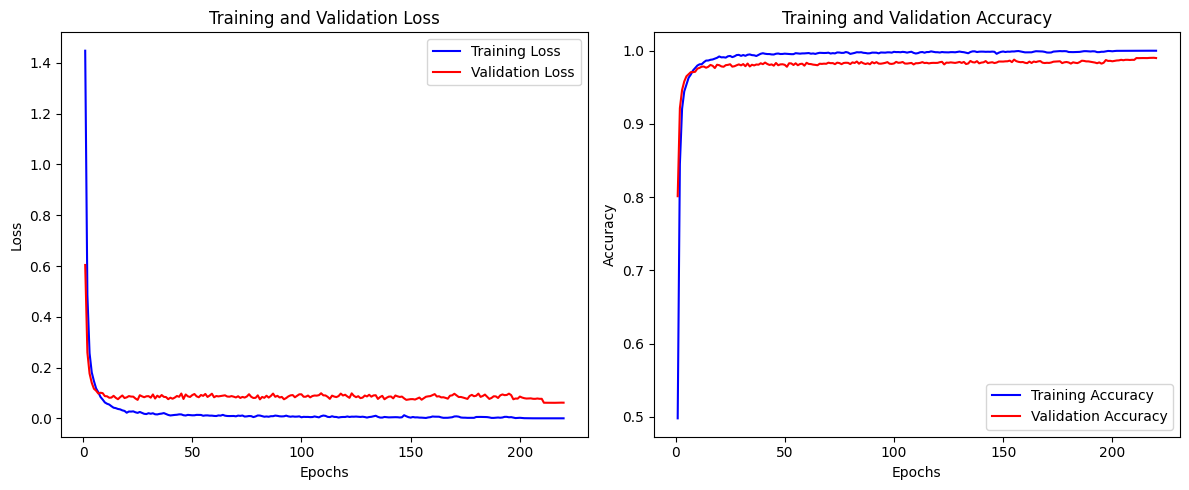

In [ ]:
import matplotlib.pyplot as plt

# Plot the training curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Create DataFrame from arrays
training_df = pd.DataFrame({
    'Epochs': epochs,
    'Training Loss': training_loss,
    'Training Accuracy': training_accuracy,
    'Validation Loss': validation_loss,
    'Validation Accuracy': validation_accuracy
})


In [ ]:
training_df.to_csv("Training_df.csv")

In [ ]:
from google.colab import files

# Assuming your model file is named 'my_model.h5'
files.download('Training_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install pydot graphviz

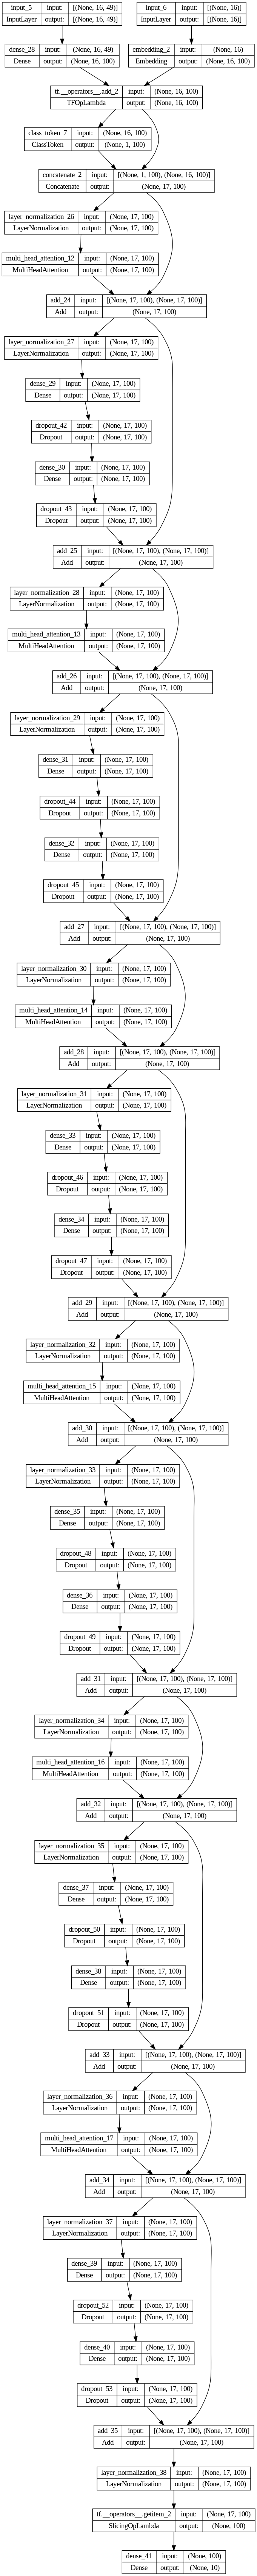

In [ ]:
from tensorflow.keras.utils import plot_model


# Save model summary to a file
with open('model_summary.txt', 'w') as f:
    trans.summary(print_fn=lambda x: f.write(x + '\n'))

# Plot the model architecture and save it as an image
plot_model(trans, to_file='transformer_model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
files.download('transformer_model_architecture.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>